In [1]:
import sys
import numpy as np
import pandas as pd
from matplotlib.pyplot import imread
import pickle, os, cv2, time
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
import keras.initializers as initializers
from keras.models import Model
from keras.layers import BatchNormalization, MaxPooling2D, Concatenate
from keras.layers import Layer, Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.regularizers import l2
from keras import backend as K
from sklearn.utils import shuffle
import numpy.random as rng

In [2]:
# Execute esta celula para carregar a rede ja treinada
import os; import gdown
url="https://drive.google.com/uc?id=1PAyiW-0_dyti5Fdp_qwgQRqGen4GwY7q"
nomeArq="oneshot.h5"
if not os.path.exists(nomeArq):
 print("Baixando o arquivo",nomeArq,"para diretorio default",os.getcwd())
 gdown.download(url, nomeArq, quiet=False)
else:
 print("O arquivo",nomeArq,"ja existe no diretorio default",os.getcwd())
model=load_model("oneshot.h5")


O arquivo oneshot.h5 ja existe no diretorio default d:\Faculdade\PSI3472\Aula_11


In [3]:
import os; 
lista=['https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip', \
     'https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip']
for url in lista:
  nomeArq=os.path.split(url)[1]
  if not os.path.exists(nomeArq):
    print("Baixando o arquivo",nomeArq,"para diretorio default",os.getcwd())
    os.system("wget -nc -U 'Firefox/50.0' "+url)
  else:
    print("O arquivo",nomeArq,"ja existe no diretorio default",os.getcwd())
  print("Descompactando arquivos novos de",nomeArq)  
  os.system("unzip -u "+nomeArq) 

Baixando o arquivo images_background.zip para diretorio default d:\Faculdade\PSI3472\Aula_11
Descompactando arquivos novos de images_background.zip
Baixando o arquivo images_evaluation.zip para diretorio default d:\Faculdade\PSI3472\Aula_11
Descompactando arquivos novos de images_evaluation.zip


In [4]:
train_folder = "./images_background/"
val_folder = './images_evaluation/'
save_path = './'
model_path = './'

# Funcao para carregar imagens
def loadimgs(path,n = 0):
    #path => Path of train directory or test directory
    X=[]; y=[]
    cat_dict = {}; lang_dict = {}; curr_y = n
    # we load every alphabet seperately so we can isolate them later
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        lang_dict[alphabet] = [curr_y,None]
        alphabet_path = os.path.join(path,alphabet)
        for letter in os.listdir(alphabet_path):
            cat_dict[curr_y] = (alphabet, letter)
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
            # read all the images in the current category
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
                y.append(curr_y)
            try:
                X.append(np.stack(category_images))
            # edge case  - last one
            except ValueError as e:
                print(e); print("error - category_images:", category_images)
            curr_y += 1
            lang_dict[alphabet][1] = curr_y - 1
    y = np.vstack(y); X = np.stack(X)
    return X,y,lang_dict

# Carrega as imagens de treino
Xtrain,ytrain,train_classes=loadimgs(train_folder)

# Carrega as imagens de teste
Xval,yval,val_classes=loadimgs(val_folder)

loading alphabet: Alphabet_of_the_Magi
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Balinese
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Burmese_(Myanmar)
loading alphabet: Cyrillic
loading alphabet: Early_Aramaic
loading alphabet: Futurama
loading alphabet: Grantha
loading alphabet: Greek
loading alphabet: Gujarati
loading alphabet: Hebrew
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Japanese_(hiragana)
loading alphabet: Japanese_(katakana)
loading alphabet: Korean
loading alphabet: Latin
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: N_Ko
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Sanskrit
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Tagalog
loading alphabet: Tifinagh
loa

In [5]:
# Funcao que pega uma lote de pares de imagens
# Duas primeiras imagens tem a mesma classe, resto diferente
def get_batch(batch_size,s="train"):
    if s == 'train':
        X = Xtrain; categories = train_classes; replace=False
    else:
        X = Xval; categories = val_classes; replace=True
    n_classes, n_examples, w, h = X.shape

    categories = rng.choice(n_classes,size=(batch_size,),replace=replace)
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    targets=np.ones((batch_size,))
    targets[0] = 0
    targets[1:batch_size]
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = X[category, idx_1].reshape(w, h, 1)
        idx_2 = rng.randint(0, n_examples)
        # pick images of same class for the two first images, different for the rest
        if i == 0:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        pairs[1][i,:,:,:] = X[category_2,idx_2].reshape(w, h,1)
    return pairs, targets

In [6]:
ax, ay = get_batch(8)

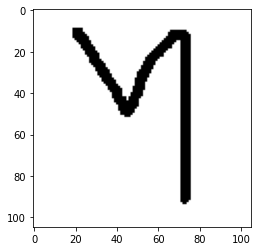

In [7]:
plt.imshow(np.squeeze(ax[0][0]), cmap="gray")

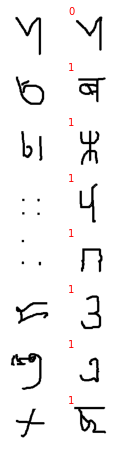

In [8]:
f = plt.figure(figsize=(2,8))
for i in range(8):
  f.add_subplot(8,2,2*i+1)
  plt.imshow(np.squeeze(ax[0][i]), cmap="gray")
  plt.axis("off");
  f.add_subplot(8,2,2*i+2)
  plt.imshow(np.squeeze(ax[1][i]), cmap="gray")
  plt.axis("off");
  plt.text(0, 2,int(ay[i]),color="r")
plt.savefig("oneshot_pares.png")
plt.show()

In [15]:
pred = 0
n = 1000
for i in range(n):
    ax, ay = get_batch(8)
    ap = model.predict(ax, verbose=0)
    pred = pred + ap[0]
precision = (n-pred)/n
print(precision)

[0.93082887]
